In [1]:
%pylab --n
%matplotlib inline
import seaborn as sns
import birdsonganalysis as bsa
from scipy.io import wavfile

sns.set_palette('colorblind')

import sys

sys.path.append('../model/')
from song_model import SongModel
from gesture_fitter import fit_gesture_padded, fit_gesture_whole
from measures import bsa_measure
from synth import synthesize

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
sr, tutor = wavfile.read('../data/ba_example.wav')

In [19]:
sm = SongModel(tutor)

In [4]:
sm.gestures[5][1] = fit_gesture_whole(bsa_measure(tutor, sr), sm, 5, lambda s: bsa_measure(s, sr), lambda g, c: np.linalg.norm(g - c), 10)[0]

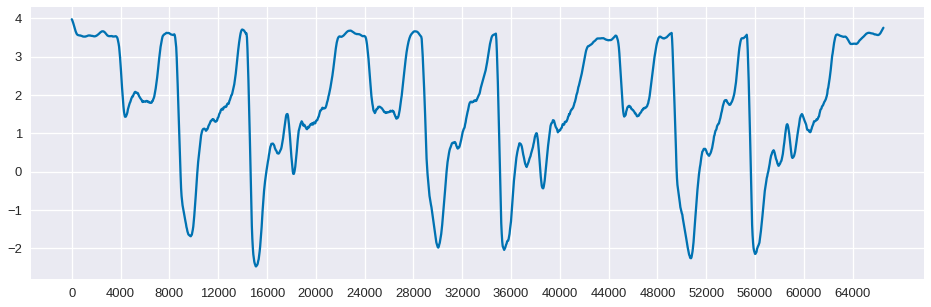

In [5]:
plt.figure(figsize=(16, 5))
wiener = bsa_measure(tutor, sr)[:, 2]
plt.plot(wiener)
plt.xticks(np.arange(len(wiener), step=100), np.arange(len(wiener), step=100)*40)
plt.show()
plt.close()

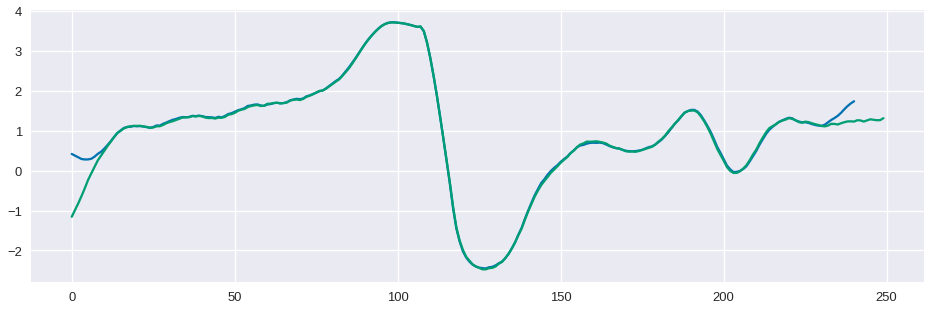

In [6]:
plt.figure(figsize=(16, 5))
plt.plot(bsa_measure(tutor[10041:20041], sr)[:, 2])
plt.plot(wiener[10041//40:20041//40])
plt.show()
plt.close()

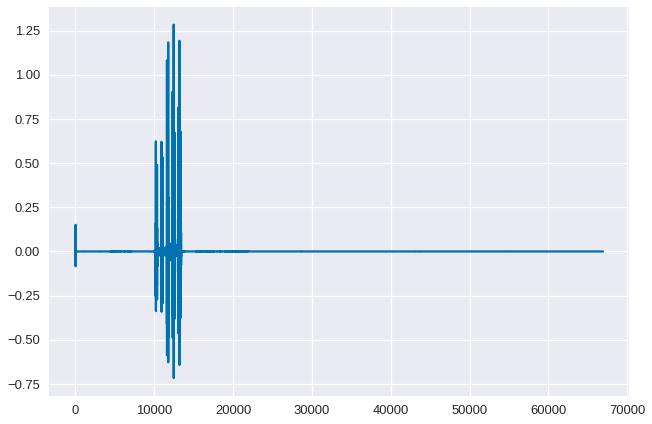

In [14]:
plt.plot(sm.gen_sound())

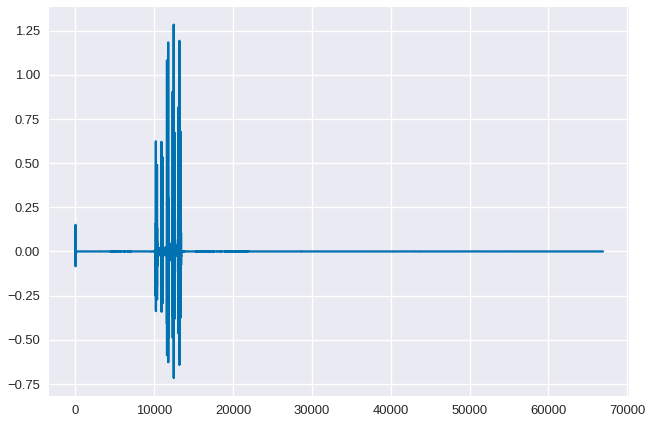

In [8]:
for gesture in sm.gestures:
    gesture[1][-1] = 1
    gesture[1][12] = 0.15
sm.gestures[3][1][1] = 3
sm.gestures[3][1][2] = 2
sm.gestures[3][1][-1] = 0
s = synthesize(sm.gen_alphabeta())
plt.plot(s)

In [9]:
from IPython.display import Audio, display
display(Audio(s, rate=44100))

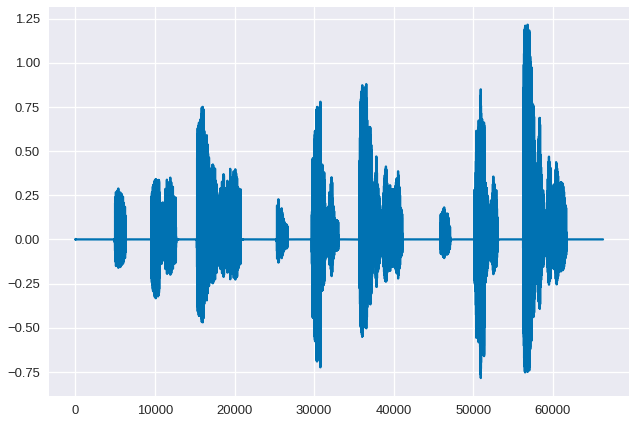

In [15]:
plt.plot(synthesize(np.loadtxt('../data/ba_example_ab.dat')))

In [16]:
Audio(synthesize(np.loadtxt('../data/ba_example_ab.dat')), rate=44100)

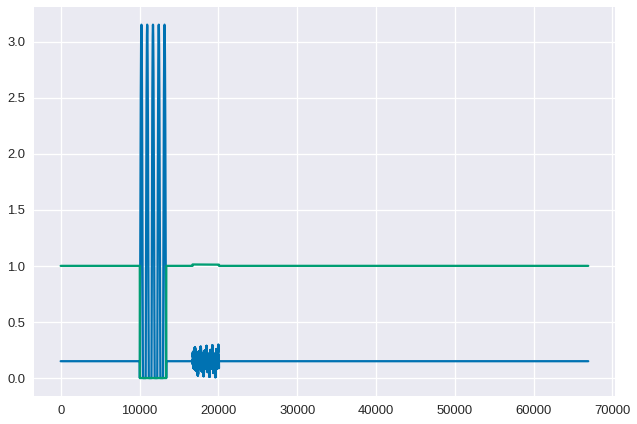

In [17]:
plt.plot(sm.gen_alphabeta())

In [20]:
sm0 = SongModel(tutor)
for gesture in sm0.gestures:
    gesture[1][-1] = -0.05 # beta
    gesture[1][12] = 0.5 # alpha

In [21]:
for i in range(len(sm0.gestures)):
    print(i)
    sm0.gestures[i][1] = fit_gesture_whole(bsa_measure(tutor, sr), sm0, i, lambda s: bsa_measure(s, sr), lambda g, c: np.linalg.norm(g - c), 10)[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


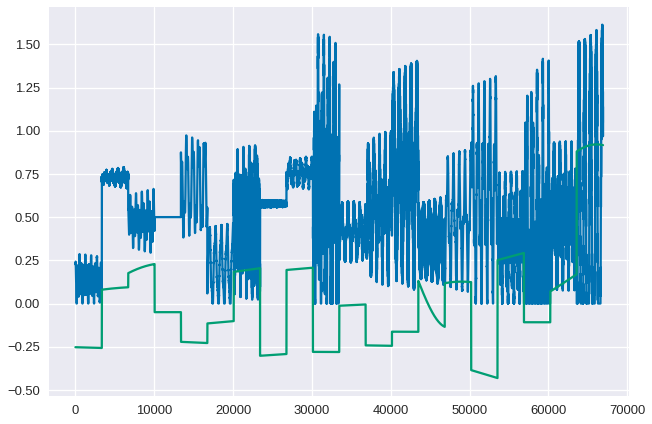

In [22]:
plt.plot(sm0.gen_alphabeta())

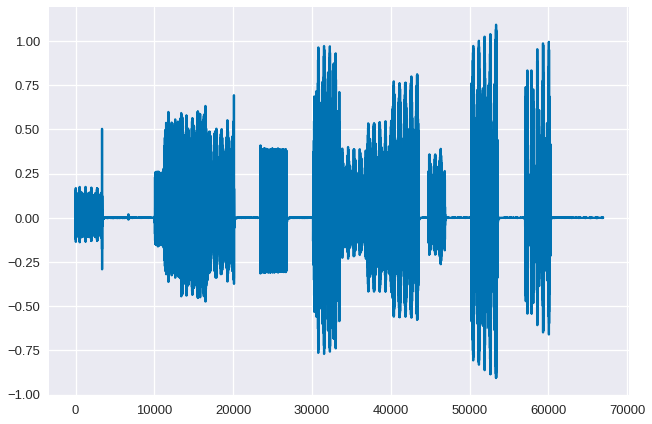

In [23]:
plt.plot(sm0.gen_sound())

In [24]:
Audio(sm0.gen_sound(), rate=44100)

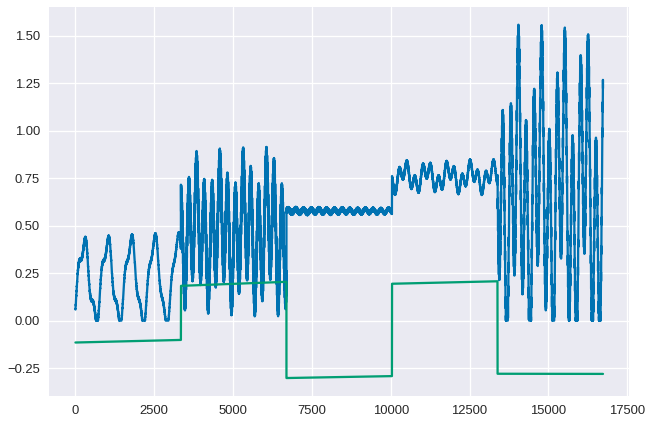

In [25]:
plt.plot(
        sm0.gen_alphabeta(range(5, 10)))


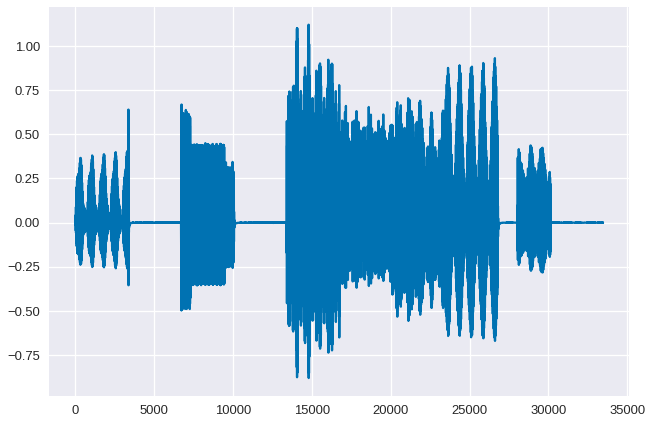

In [26]:
plt.plot(sm0.gen_sound(range(5, 15)))

In [27]:
Audio(synthesize(sm0.gen_alphabeta(range(5, 15))), rate=44100)

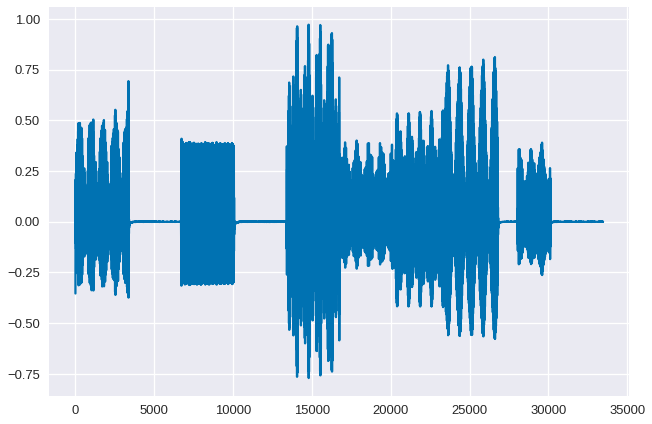

In [28]:
plt.plot(sm0.gen_sound()[sm0.gestures[5][0]:sm0.gestures[15][0]])

In [29]:
Audio(sm0.gen_sound()[sm0.gestures[5][0]:sm0.gestures[15][0]], rate=44100)

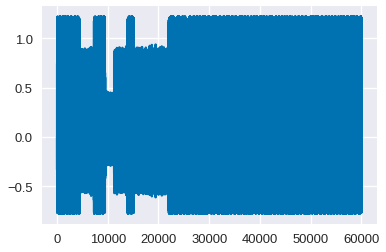

In [379]:
a = 2 * np.ones(60000)
b = -0.1 * np.ones(60000)
ab = np.stack((a, b), axis=-1)
plt.plot(synthesize(ab))

In [380]:
Audio(synthesize(ab), rate=44100)